In [1]:
import pandas as pd
import os

df_results = pd.read_csv('../results/eye-movement-prediction/baseline_results.csv', sep=',')
df_results

df_english = df_results.groupby('test_language').get_group('English').reset_index(drop=True)
df_english.groupby('model').get_group('mean').reset_index(drop=True)

,test_language,eyetracking-feature,model,mae,accuracy,r2,mse,rmse
0,English,scaled_fix_count,mean,17.254893,82.745107,-0.287098,580.767281,24.099114
1,English,scaled_first_pass_dur,mean,17.077974,82.922026,-0.404458,551.155705,23.476706
2,English,scaled_tot_fix_dur,mean,18.396756,81.603244,-0.309465,648.480748,25.465285
3,English,scaled_tot_regr_from_dur,mean,10.092968,89.907032,-0.029263,243.499693,15.604477


In [2]:
import glob

xlm_files = glob.glob(r'../results/eye-movement-prediction/results-version-1.2/*.tsv')

xlm_pred_files = [file for file in xlm_files if 'preds' in file]
xlm_result_files = [file for file in xlm_files if file.endswith('averaged.tsv') and not 'scrambled' in file and not 'permuted' in file]
xlm_scrambled_result_files = [file for file in xlm_files if file.endswith('averaged.tsv') and 'scrambled' in file]
xlm_permuted_result_files = [file for file in xlm_files if file.endswith('averaged.tsv') and 'permuted' in file]
#xlm_cls_result_files = [file for file in xlm_files if file.endswith('averaged.tsv') and 'cls' in file]

# Read in files as dataframes + add column with filenames
xlm_dfs = []
for file in xlm_result_files:
    xlm_df = pd.read_csv(file, sep='\t', header=0)
    xlm_dfs.append(xlm_df)
    
xlm_scrambled_dfs = []
for file in xlm_scrambled_result_files:
    xlm_scrambled_df = pd.read_csv(file, sep='\t', header=0)
    xlm_scrambled_dfs.append(xlm_scrambled_df)

xlm_permuted_dfs = []
for file in xlm_permuted_result_files:
    xlm_permuted_df = pd.read_csv(file, sep='\t', header=0)
    xlm_permuted_dfs.append(xlm_permuted_df)
    
# xlm_cls_dfs = []
# for file in xlm_cls_result_files:
#     xlm_cls_df = pd.read_csv(file, sep='\t', header=0)
#     xlm_cls_dfs.append(xlm_cls_df)
    
# Concatenate
xlm_frame = pd.concat(xlm_dfs, axis=0, ignore_index=True)
xlm_frame['test_language'] = [name.lstrip('eval-meco-') for name in xlm_frame['run_name']]
xlm_frame['accuracy'] = 100 - xlm_frame['mae']

xlm_scrambled_frame = pd.concat(xlm_scrambled_dfs, axis=0, ignore_index=True)
xlm_scrambled_frame['test_language'] = [name.replace('eval-meco-scrambled-', '').capitalize() for name in xlm_scrambled_frame['run_name']]
xlm_scrambled_frame['accuracy'] = 100 - xlm_scrambled_frame['mae']

xlm_permuted_frame = pd.concat(xlm_permuted_dfs, axis=0, ignore_index=True)
xlm_permuted_frame['test_language'] = [name.replace('eval-meco-permuted-', '').capitalize() for name in xlm_permuted_frame['run_name']]
xlm_permuted_frame['accuracy'] = 100 - xlm_permuted_frame['mae']

# xlm_cls_frame = pd.concat(xlm_cls_dfs, axis=0, ignore_index=True)
# xlm_cls_frame['test_language'] = [name.replace('eval-meco-cls-', '').capitalize() for name in xlm_cls_frame['run_name']]
# xlm_cls_frame['accuracy'] = 100 - xlm_permuted_frame['mae']
# xlm_cls_frame

In [3]:
language = 'English'

df_lang = df_results.groupby('test_language').get_group(language)

length_results = df_lang.groupby('model').get_group('length').reset_index(drop=True)
freq_results = df_lang.groupby('model').get_group('frequency').reset_index(drop=True)
ling_results = df_lang.groupby('model').get_group('linguistic').reset_index(drop=True)
all_feats_results = df_lang.groupby('model').get_group('all').reset_index(drop=True)
mean_results = df_lang.groupby('model').get_group('mean').reset_index(drop=True)

xlm_results = xlm_frame.groupby('test_language').get_group(language).reset_index(drop=True)
xlm_scrambled_results = xlm_scrambled_frame.groupby('test_language').get_group(language).reset_index(drop=True)
xlm_permuted_results = xlm_permuted_frame.groupby('test_language').get_group(language).reset_index(drop=True)

xlm_results

,run_name,feature,max_err,mae,mse,rmse,r2,err_std,test_language,accuracy
0,eval-meco-English,scaled_first_pass_dur,75.791950,24.382874,735.15400,27.113723,-0.873324,11.858726,English,75.617126
1,eval-meco-English,scaled_fix_count,58.059742,25.550797,737.67816,27.160231,-0.634844,9.210592,English,74.449203
2,eval-meco-English,scaled_tot_fix_dur,65.287025,26.713870,816.48400,28.574184,-0.648711,10.141660,English,73.286130
3,eval-meco-English,scaled_tot_regr_from_dur,82.231964,17.453695,462.98050,21.516982,-0.957000,12.583679,English,82.546305


In [4]:
def get_results(results, eval_metric='accuracy'):
    
    fxc = results.loc[0].at[eval_metric]
    fpd = results.loc[1].at[eval_metric]
    tfd = results.loc[2].at[eval_metric]
    rd = results.loc[3].at[eval_metric]
    
    return fxc, fpd, tfd, rd

def get_results_xlm(results, eval_metric='accuracy'):
    
    fxc = results.loc[1].at[eval_metric]
    fpd = results.loc[0].at[eval_metric]
    tfd = results.loc[2].at[eval_metric]
    rd = results.loc[3].at[eval_metric]
    
    return fxc, fpd, tfd, rd

def get_improvement_over_mean(mean_results, other_results, eval_metric='accuracy'):
    
    mean_fxc = mean_results.loc[0].at[eval_metric]
    mean_fpd = mean_results.loc[1].at[eval_metric]
    mean_tfd = mean_results.loc[2].at[eval_metric]
    mean_rd = mean_results.loc[3].at[eval_metric]
    
    fxc = other_results.loc[0].at[eval_metric]
    fpd = other_results.loc[1].at[eval_metric]
    tfd = other_results.loc[2].at[eval_metric]
    rd = other_results.loc[3].at[eval_metric]

    new_fxc = fxc - mean_fxc
    new_fpd = fpd - mean_fpd
    new_tfd = tfd - mean_tfd
    new_rd = rd - mean_rd
    
    return new_fxc, new_fpd, new_tfd, new_rd

def get_improvement_over_mean_xlm(mean_results, other_results, eval_metric='accuracy'):
    
    mean_fxc = mean_results.loc[0].at[eval_metric]
    mean_fpd = mean_results.loc[1].at[eval_metric]
    mean_tfd = mean_results.loc[2].at[eval_metric]
    mean_rd = mean_results.loc[3].at[eval_metric]
    
    fxc = other_results.loc[1].at[eval_metric]
    fpd = other_results.loc[0].at[eval_metric]
    tfd = other_results.loc[2].at[eval_metric]
    rd = other_results.loc[3].at[eval_metric]

    new_fxc = fxc - mean_fxc
    new_fpd = fpd - mean_fpd
    new_tfd = tfd - mean_tfd
    new_rd = rd - mean_rd
    
    return new_fxc, new_fpd, new_tfd, new_rd

  eye-tracking metric  length svm  frequency svm  structural svm  \
0      first-pass dur    0.888083       0.286156        0.753640   
1           fix count    1.009667       0.423612        0.866872   
2       total fix dur    1.014034       0.424375        0.850232   
3      regression dur   -0.044691       0.017280       -0.021951   

   all features svm  fine-tuned xlm  
0          0.883289       -0.468866  
1          0.992930       -0.347746  
2          1.002027       -0.339246  
3         -0.063540       -0.927736  
AxesSubplot(0.125,0.125;0.775x0.755)


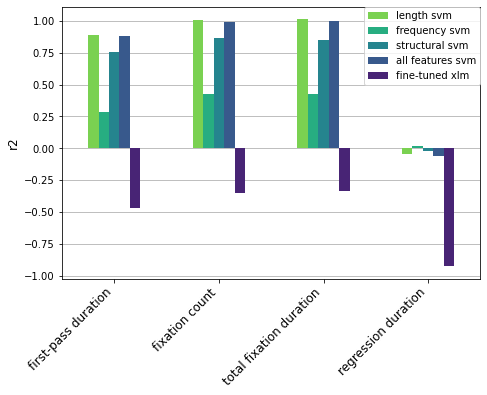

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

eval_metric = 'r2'
language = 'English'

df_lang = df_results.groupby('test_language').get_group(language)

length_results = df_lang.groupby('model').get_group('length').reset_index(drop=True)
freq_results = df_lang.groupby('model').get_group('frequency').reset_index(drop=True)
ling_results = df_lang.groupby('model').get_group('linguistic').reset_index(drop=True)
all_feats_results = df_lang.groupby('model').get_group('all').reset_index(drop=True)
mean_results = df_lang.groupby('model').get_group('mean').reset_index(drop=True)

xlm_results = xlm_frame.groupby('test_language').get_group(language).reset_index(drop=True)

fxc_len, fpd_len, tfd_len, rd_len = get_improvement_over_mean(mean_results, length_results, eval_metric)
fxc_frq, fpd_frq, tfd_frq, rd_frq = get_improvement_over_mean(mean_results, freq_results, eval_metric)
fxc_ling, fpd_ling, tfd_ling, rd_ling = get_improvement_over_mean(mean_results, ling_results, eval_metric)
fxc_all, fpd_all, tfd_all, rd_all = get_improvement_over_mean(mean_results, all_feats_results, eval_metric)
fxc_xlm, fpd_xlm, tfd_xlm, rd_xlm = get_improvement_over_mean_xlm(mean_results, xlm_results, eval_metric)

# fxc_len, fpd_len, tfd_len, rd_len = get_results(length_results, eval_metric)
# fxc_frq, fpd_frq, tfd_frq, rd_frq = get_results(freq_results, eval_metric)
# fxc_ling, fpd_ling, tfd_ling, rd_ling = get_results(ling_results, eval_metric)
# fxc_all, fpd_all, tfd_all, rd_all = get_results(all_feats_results, eval_metric)
# fxc_xlm, fpd_xlm, tfd_xlm, rd_xlm = get_results(xlm_results, eval_metric)

# create data
df = pd.DataFrame([['first-pass dur', fpd_len, fpd_frq, fpd_ling, fpd_all, fpd_xlm],
                   ['fix count', fxc_len, fxc_frq, fxc_ling, fxc_all, fxc_xlm],
                   ['total fix dur', tfd_len, tfd_frq, tfd_ling, tfd_all, tfd_xlm],
                   ['regression dur', rd_len, rd_frq, rd_ling, rd_all, rd_xlm]],
                  columns=['eye-tracking metric', 'length svm', 'frequency svm', 'structural svm', 'all features svm', 'fine-tuned xlm'])

print(df)
# plot grouped bar chart
ax = df.plot(x='eye-tracking metric',
        kind='bar',
#         ylim = (-1, 1),
        stacked=False,
        color = cm.viridis_r(np.linspace(0.2, 0.9, 5)),
        xticks=df.index, rot=45,
        zorder=3,
        figsize=(7.5,5))

ax.grid(axis='y', zorder=0)
#ax.set_xlabel(f'Eye-tracking metrics (test set = MECO {language})')
ax.set_xlabel('')
ax.set_ylabel(f'{eval_metric}', fontsize=12)
ax.set_xticklabels(['first-pass duration', 'fixation count', 'total fixation duration', 'regression duration'], horizontalalignment='right', fontsize=12)
ax.legend(loc='upper right', borderaxespad=0, fontsize=10)
print(ax)

#plt.savefig('feature-based-prediction.pdf', dpi=300, bbox_inches='tight', transparent=False)

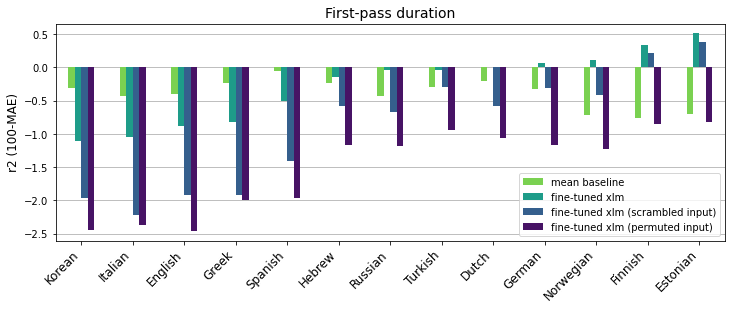

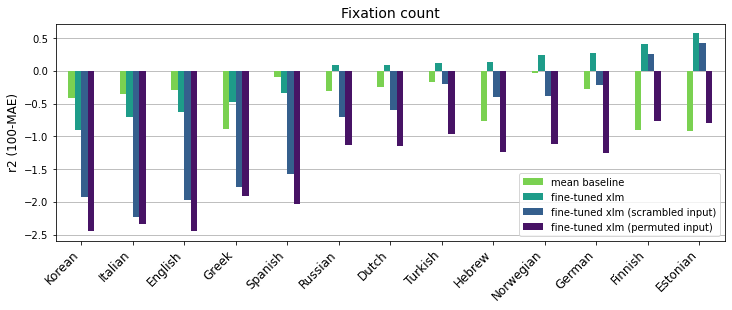

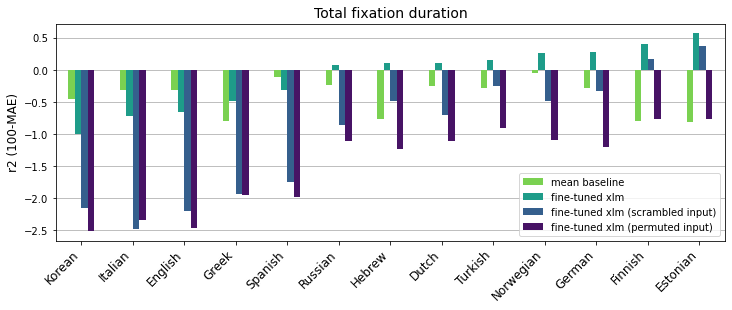

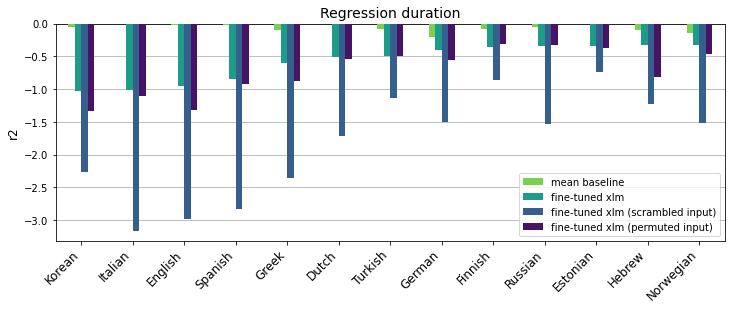

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

languages = ['Estonian', 'Italian', 'English', 'Dutch', 'Finnish', 'Hebrew', 'Russian', 'Turkish', 'Korean', 'German', 'Greek', 'Spanish', 'Norwegian']
eval_metric = 'r2'

data_fpd = []
data_fxc = []
data_tfd = []
data_rd = []
      
for language in languages:

    df_lang = df_results.groupby('test_language').get_group(language)
#     length_results = df_lang.groupby('model').get_group('length').reset_index(drop=True)
#     all_feats_results = df_lang.groupby('model').get_group('all').reset_index(drop=True)
    mean_results = df_lang.groupby('model').get_group('mean').reset_index(drop=True)

    xlm_results = xlm_frame.groupby('test_language').get_group(language).reset_index(drop=True)
    xlm_scrambled_results = xlm_scrambled_frame.groupby('test_language').get_group(language).reset_index(drop=True)
    xlm_permuted_results = xlm_permuted_frame.groupby('test_language').get_group(language).reset_index(drop=True)
#     xlm_cls_results = xlm_cls_frame.groupby('test_language').get_group(language).reset_index(drop=True)

#     fxc_len, fpd_len, tfd_len, rd_len = get_improvement_over_mean(mean_results, length_results, eval_metric)
#     fxc_frq, fpd_frq, tfd_frq, rd_frq = get_improvement_over_mean(mean_results, freq_results, eval_metric)
#     fxc_ling, fpd_ling, tfd_ling, rd_ling = get_improvement_over_mean(mean_results, ling_results, eval_metric)
#     fxc_all, fpd_all, tfd_all, rd_all = get_improvement_over_mean(mean_results, all_feats_results, eval_metric)
#     fxc_xlm, fpd_xlm, tfd_xlm, rd_xlm = get_improvement_over_mean_xlm(mean_results, xlm_results, eval_metric)
    
    fxc_mean, fpd_mean, tfd_mean, rd_mean = get_results(mean_results, eval_metric)
#     fxc_len, fpd_len, tfd_len, rd_len = get_results(length_results, eval_metric)
#     fxc_all, fpd_all, tfd_all, rd_all = get_results(all_feats_results, eval_metric)
    fxc_xlm, fpd_xlm, tfd_xlm, rd_xlm = get_results_xlm(xlm_results, eval_metric)
    fxc_xlm_scrambled, fpd_xlm_scrambled, tfd_xlm_scrambled, rd_xlm_scrambled = get_results_xlm(xlm_scrambled_results, eval_metric)
    fxc_xlm_permuted, fpd_xlm_permuted, tfd_xlm_permuted, rd_xlm_permuted = get_results_xlm(xlm_permuted_results, eval_metric)
#     fxc_xlm_cls, fpd_xlm_cls, tfd_xlm_cls, rd_xlm_cls = get_results_xlm(xlm_cls_results, eval_metric)
        
    data_fpd.append([f'{language}',  fpd_mean, fpd_xlm, fpd_xlm_scrambled, fpd_xlm_permuted])
    data_fxc.append([f'{language}',  fxc_mean, fxc_xlm,  fxc_xlm_scrambled, fxc_xlm_permuted])
    data_tfd.append([f'{language}',  tfd_mean, tfd_xlm,  tfd_xlm_scrambled, tfd_xlm_permuted])
    data_rd.append([f'{language}',  rd_mean, rd_xlm, rd_xlm_scrambled, rd_xlm_permuted])

# create dataframes
df_fpd = pd.DataFrame(data_fpd, columns=['language', 'mean baseline', 'fine-tuned xlm', 'fine-tuned xlm (scrambled input)', 'fine-tuned xlm (permuted input)'])
df_fpd_sorted = df_fpd.sort_values(by=['fine-tuned xlm'], ascending=True).reset_index(drop=True)
      
df_fxc = pd.DataFrame(data_fxc, columns=['language', 'mean baseline', 'fine-tuned xlm', 'fine-tuned xlm (scrambled input)', 'fine-tuned xlm (permuted input)'])
df_fxc_sorted = df_fxc.sort_values(by=['fine-tuned xlm'], ascending=True).reset_index(drop=True)

df_tfd = pd.DataFrame(data_tfd, columns=['language', 'mean baseline','fine-tuned xlm', 'fine-tuned xlm (scrambled input)', 'fine-tuned xlm (permuted input)'])
df_tfd_sorted = df_tfd.sort_values(by=['fine-tuned xlm'], ascending=True).reset_index(drop=True)
      
df_rd = pd.DataFrame(data_rd, columns=['language', 'mean baseline', 'fine-tuned xlm', 'fine-tuned xlm (scrambled input)', 'fine-tuned xlm (permuted input)'])
df_rd_sorted = df_rd.sort_values(by=['fine-tuned xlm'], ascending=True).reset_index(drop=True)

# plot grouped bar chart
ax1 = df_fpd_sorted.plot(x='language',
        kind='bar',
        #ylim = (-1,1),
        stacked=False,
        ylabel=f'{eval_metric}',
        color = cm.viridis_r(np.linspace(0.2, 1.2, 5)),
        xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], rot=45, zorder=3,
        figsize=(12,4),
        title='First-pass duration')

ax1.grid(axis='y', zorder=0)
ax1.set_title('First-pass duration', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel(f'{eval_metric} (100-MAE)', fontsize=12)
ax1.set_xticklabels(df_fpd_sorted['language'], horizontalalignment='right', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)

# plt.savefig('fpd-crosslingual-accuracy-new.pdf', dpi=300, bbox_inches='tight')
      
# plot grouped bar chart
ax2 = df_fxc_sorted.plot(x='language',
        kind='bar',
       # ylim = (-1,1),
        stacked=False,
        ylabel=f'{eval_metric}',
        color = cm.viridis_r(np.linspace(0.2, 1.2, 5)),
        xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], rot=45, zorder=3,
        figsize=(12,4),
        title='Fixation count')

ax2.grid(axis='y', zorder=0)
ax2.set_title('Fixation count', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel(f'{eval_metric} (100-MAE)', fontsize=12)
ax2.set_xticklabels(df_fxc_sorted['language'], horizontalalignment='right', fontsize=12)
ax2.legend(loc='lower right', fontsize=10)

# plt.savefig('fxc-crosslingual-accuracy-new.pdf', dpi=300, bbox_inches='tight')
      
# plot grouped bar chart
ax3 = df_tfd_sorted.plot(x='language',
        kind='bar',
       # ylim = (-1,1),
        stacked=False,
        color = cm.viridis_r(np.linspace(0.2, 1.2, 5)),
        xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], rot=45, zorder=3,
        figsize=(12,4))

ax3.grid(axis='y', zorder=0)
ax3.set_title('Total fixation duration', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel(f'{eval_metric} (100-MAE)', fontsize=12)
ax3.set_xticklabels(df_tfd_sorted['language'], horizontalalignment='right', fontsize=12)
ax3.legend(loc='lower right', fontsize=10)

# plt.savefig('tfd-crosslingual-accuracy-new.pdf', dpi=300, bbox_inches='tight')
      
# plot grouped bar chart
ax4 = df_rd_sorted.plot(x='language',
        kind='bar',
        #ylim = (-1,1),
        stacked=False,
        ylabel=f'{eval_metric}',
        color = cm.viridis_r(np.linspace(0.2, 1.2, 5)),
        xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], rot=45, zorder=3,
        figsize=(12,4))

ax4.grid(axis='y', zorder=0)
ax4.set_title('Regression duration', fontsize=14)
ax4.set_xlabel('')
ax4.set_ylabel(f'{eval_metric}', fontsize=12)
ax4.set_xticklabels(df_rd_sorted['language'], horizontalalignment='right', fontsize=12)
ax4.legend(loc='lower right', fontsize=10)
    
# plt.savefig('rd-crosslingual-accuracy-new.pdf', dpi=300, bbox_inches='tight')

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm

# eval_metric = 'accuracy'

# fpd_len = length_results.loc[1].at[eval_metric]
# fpd_frq = freq_results.loc[1].at[eval_metric]
# fpd_ling = ling_results.loc[1].at[eval_metric]
# fpd_all = all_feats_results.loc[1].at[eval_metric]
# fpd_mean = mean_results.loc[1].at[eval_metric]
# fpd_xlm = xlm_results.loc[0].at[eval_metric]

# fxc_len = length_results.loc[0].at[eval_metric]
# fxc_frq = freq_results.loc[0].at[eval_metric]
# fxc_ling = ling_results.loc[0].at[eval_metric]
# fxc_all = all_feats_results.loc[0].at[eval_metric]
# fxc_mean = mean_results.loc[0].at[eval_metric]
# fxc_xlm = xlm_results.loc[1].at[eval_metric]

# tfd_len = length_results.loc[2].at[eval_metric]
# tfd_frq = freq_results.loc[2].at[eval_metric]
# tfd_ling = ling_results.loc[2].at[eval_metric]
# tfd_all = all_feats_results.loc[2].at[eval_metric]
# tfd_mean = mean_results.loc[2].at[eval_metric]
# tfd_xlm = xlm_results.loc[2].at[eval_metric]

# rd_len = length_results.loc[3].at[eval_metric]
# rd_frq = freq_results.loc[3].at[eval_metric]
# rd_ling = ling_results.loc[3].at[eval_metric]
# rd_all = all_feats_results.loc[3].at[eval_metric]
# rd_mean = mean_results.loc[3].at[eval_metric]
# rd_xlm = xlm_results.loc[3].at[eval_metric]

# # create data
# df = pd.DataFrame([['first-pass dur', fpd_mean, fpd_len, fpd_frq, fpd_ling, fpd_all, fpd_xlm],
#                    ['fix count', fxc_mean, fxc_len, fxc_frq, fxc_ling, fxc_all, fxc_xlm],
#                    ['total fix dur', tfd_mean, tfd_len, tfd_frq, tfd_ling, tfd_all, tfd_xlm],
#                    ['regression dur', rd_mean, rd_len, rd_frq, rd_ling, rd_all, rd_xlm]],
#                   columns=['eye-tracking metric', 'mean', 'length', 'frequency', 'ling feats', 'all feats', 'xlm'])

# df.T.to_csv('absolute_acc.csv', encoding='utf8', index=False, sep='\t')

# # plot grouped bar chart
# ax = df.plot(x='eye-tracking metric',
#         kind='bar',
#         stacked=False,
#         ylabel=eval_metric,
#         color = cm.viridis_r(np.linspace(0.2, 0.9, 5)),
#         xticks=df.index, rot=45,
#         zorder=3)

# ax.grid(axis='y', zorder=0)

# ax.set_xticklabels(['first-pass duration', 'fixation count', 'total fixation duration', 'regression duration'], horizontalalignment='right')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# print(ax)

**Probing results**:

In [1]:
import pandas as pd

pretrained_probing_results = pd.read_csv('../results/probing/results_probe-xlm-pretrained-mean.tsv', sep='\t')

# Add column with language

names = pretrained_probing_results['run_name'].tolist()

languages = []
for name in names:
    if 'English' in name:
        languages.append('en')
    elif 'Turkish' in name:
        languages.append('tr')
    elif 'Korean' in name:
        languages.append('ko')
        
pretrained_probing_results['language'] = languages

# For each language, get the mean result per feature

pretrained_results_per_language = pretrained_probing_results.groupby(['language', 'feature'], as_index=False).mean()
pretrained_results_per_language['accuracy'] = 100 - pretrained_results_per_language['mae']
pretrained_results_per_language

,language,feature,max_err,mae,mse,rmse,r2,err_std,accuracy
0,en,scaled_avg_links_len,49.291171,13.377525,271.068944,16.460899,-0.222897,9.589439,86.622475
1,en,scaled_avg_max_depth,0.489713,0.405587,0.165623,0.406967,0.000000,0.033414,99.594413
2,en,scaled_avg_token_freq,53.613008,11.427200,221.025732,14.804596,-0.013744,9.411247,88.572800
3,en,scaled_avg_word_length,39.085258,7.437177,94.780415,9.673469,-0.002268,6.167466,92.562823
4,en,scaled_lexical_density,40.567475,7.781371,99.824141,9.959830,0.000482,6.214323,92.218629
5,en,scaled_max_links_len,64.416053,11.739544,246.513864,15.664484,-0.008170,10.367352,88.260456
6,en,scaled_n_low_freq_words,72.512333,13.057927,296.786108,17.189719,0.003550,11.173959,86.942073
7,en,scaled_token_count,56.453807,10.831001,189.471272,13.750888,-0.004554,8.460996,89.168999
8,en,scaled_verbal_head_per_sent,66.260254,12.160557,246.758306,15.696705,0.007405,9.903777,87.839443
9,ko,scaled_avg_links_len,47.799187,10.065258,156.722311,12.464044,-0.201437,7.343930,89.934742


In [23]:
finetuned_probing_results = pd.read_csv('../results/probing/results_probe-xlm-finetuned-cls.tsv', sep='\t')

# Add column with language

names = finetuned_probing_results['run_name'].tolist()

languages = []
for name in names:
    if 'English' in name:
        languages.append('en')
    elif 'Turkish' in name:
        languages.append('tr')
    elif 'Korean' in name:
        languages.append('ko')
        
finetuned_probing_results['language'] = languages

# For each language, get the mean result per feature

finetuned_results_per_language = finetuned_probing_results.groupby(['language', 'feature'], as_index=False).mean()
finetuned_results_per_language['accuracy'] = 100 - finetuned_results_per_language['mae']
finetuned_results_per_language

,language,feature,max_err,mae,mse,rmse,r2,err_std,accuracy
0,en,scaled_avg_links_len,53.744859,11.802306,219.259018,14.803673,0.010818,8.933292,88.197694
1,en,scaled_avg_max_depth,0.574384,0.203029,0.048813,0.220866,0.000000,0.086531,99.796971
2,en,scaled_avg_token_freq,52.073528,11.462008,217.518286,14.685424,0.002676,9.179107,88.537992
3,en,scaled_avg_word_length,38.836561,7.368593,93.262826,9.594130,0.014230,6.122285,92.631407
4,en,scaled_lexical_density,40.337797,7.781363,99.601948,9.950388,0.002079,6.198756,92.218637
5,en,scaled_max_links_len,66.468828,11.696876,253.303156,15.880560,-0.036376,10.736995,88.303124
6,en,scaled_n_low_freq_words,69.309374,12.763621,283.950276,16.818905,0.045250,10.948551,87.236379
7,en,scaled_token_count,52.191050,9.950267,165.011846,12.830762,0.125972,8.092358,90.049733
8,en,scaled_verbal_head_per_sent,66.332563,12.144125,248.893640,15.765475,-0.001428,10.033074,87.855875
9,ko,scaled_avg_links_len,49.851876,8.930143,130.763049,11.376304,0.000465,7.023373,91.069857


In [24]:
target_feats = ['scaled_token_count', 'scaled_avg_word_length',             
                'scaled_lexical_density',                                                  
                'scaled_avg_max_depth', 'scaled_avg_links_len', 'scaled_max_links_len', 'scaled_verbal_head_per_sent', 
                'scaled_avg_token_freq', 'scaled_n_low_freq_words']                                    

name_mapping = {'scaled_token_count': 'sentence length (tokens)',
                'scaled_avg_word_length': 'avg. word length (characters)',
                'scaled_lexical_density': 'lexical density',
                'scaled_avg_max_depth': 'parse tree depth',
                'scaled_avg_links_len': 'avg. dependency link length',
                'scaled_max_links_len': 'max. dependency link length',
                'scaled_verbal_head_per_sent': 'number of verbal heads',
                'scaled_avg_token_freq': 'avg. word frequency',
                'scaled_n_low_freq_words': 'number of low frequency words'}

pretrained_results_per_language['feature_renamed'] = [name_mapping[feature] for feature in pretrained_results_per_language['feature'].tolist()]
finetuned_results_per_language['feature_renamed'] = [name_mapping[feature] for feature in finetuned_results_per_language['feature'].tolist()]
finetuned_results_per_language

,language,feature,max_err,mae,mse,rmse,r2,err_std,accuracy,feature_renamed
0,en,scaled_avg_links_len,53.744859,11.802306,219.259018,14.803673,0.010818,8.933292,88.197694,avg. dependency link length
1,en,scaled_avg_max_depth,0.574384,0.203029,0.048813,0.220866,0.000000,0.086531,99.796971,parse tree depth
2,en,scaled_avg_token_freq,52.073528,11.462008,217.518286,14.685424,0.002676,9.179107,88.537992,avg. word frequency
3,en,scaled_avg_word_length,38.836561,7.368593,93.262826,9.594130,0.014230,6.122285,92.631407,avg. word length (characters)
4,en,scaled_lexical_density,40.337797,7.781363,99.601948,9.950388,0.002079,6.198756,92.218637,lexical density
5,en,scaled_max_links_len,66.468828,11.696876,253.303156,15.880560,-0.036376,10.736995,88.303124,max. dependency link length
6,en,scaled_n_low_freq_words,69.309374,12.763621,283.950276,16.818905,0.045250,10.948551,87.236379,number of low frequency words
7,en,scaled_token_count,52.191050,9.950267,165.011846,12.830762,0.125972,8.092358,90.049733,sentence length (tokens)
8,en,scaled_verbal_head_per_sent,66.332563,12.144125,248.893640,15.765475,-0.001428,10.033074,87.855875,number of verbal heads
9,ko,scaled_avg_links_len,49.851876,8.930143,130.763049,11.376304,0.000465,7.023373,91.069857,avg. dependency link length


AxesSubplot(0.125,0.125;0.775x0.755)


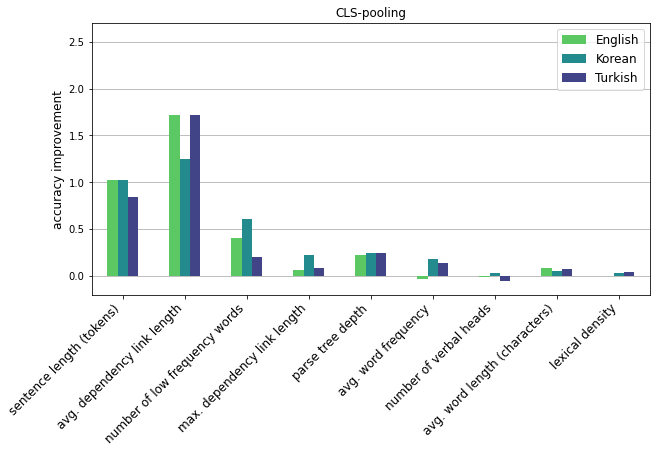

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

eval_metric = 'accuracy'

# get results for the chosen language, both finetuned and pretrained
df_pretrained_en = pretrained_results_per_language.groupby('language').get_group('en').reset_index(drop=True)
df_finetuned_en = finetuned_results_per_language.groupby('language').get_group('en').reset_index(drop=True)

df_pretrained_ko = pretrained_results_per_language.groupby('language').get_group('ko').reset_index(drop=True)
df_finetuned_ko = finetuned_results_per_language.groupby('language').get_group('ko').reset_index(drop=True)

df_pretrained_tr = pretrained_results_per_language.groupby('language').get_group('tr').reset_index(drop=True)
df_finetuned_tr = finetuned_results_per_language.groupby('language').get_group('tr').reset_index(drop=True)

# features and indeces are the same for the pretrained and finetuned dataframe and for each language
features = ['sentence length (tokens)', 'avg. dependency link length', 'number of low frequency words',
           'max. dependency link length', 'parse tree depth', 'avg. word frequency', 'number of verbal heads', 
            'avg. word length (characters)', 'lexical density']

probing_data = []
for feature in features:
    
    data_per_feature = []
    
    index = df_pretrained_en.loc[df_pretrained_en['feature_renamed'] == feature].index.tolist()[0]

    # english
    results_pretrained_en = df_pretrained_en.groupby('feature_renamed').get_group(feature)
    results_finetuned_en = df_finetuned_en.groupby('feature_renamed').get_group(feature)

    score_pretrained_en = results_pretrained_en.loc[index].at[eval_metric]
    score_finetuned_en = results_finetuned_en.loc[index].at[eval_metric]
    
    difference_en = score_finetuned_en - score_pretrained_en
    
    # korean
    results_pretrained_ko = df_pretrained_ko.groupby('feature_renamed').get_group(feature)
    results_finetuned_ko = df_finetuned_ko.groupby('feature_renamed').get_group(feature)
    
    score_pretrained_ko = results_pretrained_ko.loc[index].at[eval_metric]
    score_finetuned_ko = results_finetuned_ko.loc[index].at[eval_metric]
    
    difference_ko = score_finetuned_ko - score_pretrained_ko
    
    # turkish
    results_pretrained_tr = df_pretrained_tr.groupby('feature_renamed').get_group(feature)
    results_finetuned_tr = df_finetuned_tr.groupby('feature_renamed').get_group(feature)
    
    score_pretrained_tr = results_pretrained_tr.loc[index].at[eval_metric]
    score_finetuned_tr = results_finetuned_tr.loc[index].at[eval_metric]
    
    difference_tr = score_finetuned_tr - score_pretrained_tr
    
    # collect all data
    data_per_feature.extend([feature, difference_en, difference_ko, difference_tr])
    probing_data.append(data_per_feature)

df = pd.DataFrame(probing_data,
                  columns=['linguistic feature', 'English', 'Korean', 'Turkish'])

# plot grouped bar chart
ax = df.plot(x='linguistic feature',
        kind='bar',
        stacked=False,
        color = cm.viridis_r(np.linspace(0.25, 1.35, 5)),
        xticks=df.index, rot=45,
        zorder=3,
        figsize=(10,5),
        ylim=(-0.2,2.7))

ax.grid(axis='y', zorder=0)

ax.set_xticklabels(features, horizontalalignment='right', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel(f'{eval_metric} improvement', fontsize=12)
ax.legend(fontsize=12)
ax.set_title('CLS-pooling')
#ax.get_legend().remove()
print(ax)

#plt.savefig('plots/cls-probing-xlm-pretrained-vs-finetuned.pdf', dpi=300, bbox_inches='tight')

[<BarContainer object of 4 artists>, <BarContainer object of 4 artists>] ['Finnish', 'Turkish']


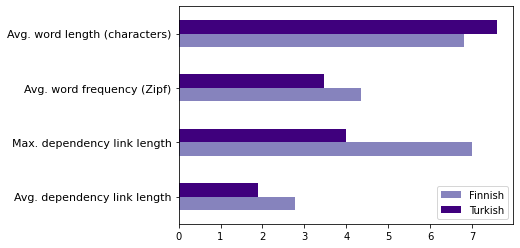

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

df = pd.DataFrame()

features = ['Avg. dependency link length', 'Max. dependency link length', 'Avg. word frequency (Zipf)', 'Avg. word length (characters)']

df['linguistic feature'] = features

df['Finnish'] = [2.7777777777777777,7,4.357,6.8]
df['Turkish'] = [1.9,4,3.4550000000000005,7.6]


# plot grouped bar chart
ax = df.plot.barh(color = cm.Purples(np.linspace(0.6, 1.4, 3)),)
# ax = df.plot(x='linguistic feature',
#         kind='bar',
#         stacked=False,
#         color = cm.viridis_r(np.linspace(0.25, 1.35, 5)),
#         xticks=df.index, rot=45,
#         zorder=3,
#         figsize=(10,5))

# ax.grid(axis='y', zorder=0)

ax.set_yticklabels(features, horizontalalignment='right', fontsize=11)
# ax.set_xlabel('')
# ax.set_ylabel('value', fontsize=12)
# ax.legend(fontsize=12)
# #ax.get_legend().remove()
# print(ax)

handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels)

#plt.savefig('plots/fi-vs-tr.pdf', dpi=300, bbox_inches='tight')

In [20]:
import glob
import pandas as pd

probe_files = glob.glob(r'../results/eye-movement-prediction/results-version-1.2/results_probe*cls.tsv')

pretrained_files = [file for file in probe_files if 'pretrained' in file]
finetuned_files = [file for file in probe_files if 'finetuned' in file]

# Read in files as dataframes + add column with filenames
pretrained_dfs = []
for file in pretrained_files:
    df = pd.read_csv(file, sep='\t', names=['run_name', 'feature', 'max_err', 'mae', 'mse', 'rmse', 'r2', 'err_std'])
    pretrained_dfs.append(df)
    
finetuned_dfs = []
for file in finetuned_files:
    df = pd.read_csv(file, sep='\t', names=['run_name', 'feature', 'max_err', 'mae', 'mse', 'rmse', 'r2', 'err_std'])
    finetuned_dfs.append(df)
    
# Concatenate
pretrained_frame = pd.concat(pretrained_dfs, axis=0, ignore_index=True)
pretrained_frame['language'] = 45 * ['English'] + 45 * ['Korean'] + 45 * ['Turkish']
pretrained_frame['accuracy'] = 100 - pretrained_frame['mae']

finetuned_frame = pd.concat(finetuned_dfs, axis=0, ignore_index=True)
finetuned_frame['language'] = 45 * ['English'] + 45 * ['Korean'] + 45 * ['Turkish']
finetuned_frame['accuracy'] = 100 - finetuned_frame['mae']

In [21]:
target_feats = ['scaled_token_count', 'scaled_avg_word_length',             
                'scaled_lexical_density',                                                  
                'scaled_avg_max_depth', 'scaled_avg_links_len', 'scaled_max_links_len', 'scaled_verbal_head_per_sent', 
                'scaled_avg_token_freq', 'scaled_n_low_freq_words']                                    

name_mapping = {'scaled_token_count': 'sentence length (tokens)',
                'scaled_avg_word_length': 'avg. word length (characters)',
                'scaled_lexical_density': 'lexical density',
                'scaled_avg_max_depth': 'parse tree depth',
                'scaled_avg_links_len': 'avg. dependency link length',
                'scaled_max_links_len': 'max. dependency link length',
                'scaled_verbal_head_per_sent': 'number of verbal heads',
                'scaled_avg_token_freq': 'avg. word frequency',
                'scaled_n_low_freq_words': 'number of low frequency words'}

pretrained_frame['feature'] = [name_mapping[feature] for feature in pretrained_frame['feature'].tolist()]
finetuned_frame['feature'] = [name_mapping[feature] for feature in finetuned_frame['feature'].tolist()]

['sentence length (tokens)', 'avg. word length (characters)', 'lexical density', 'parse tree depth', 'avg. dependency link length', 'max. dependency link length', 'number of verbal heads', 'avg. word frequency', 'number of low frequency words']
AxesSubplot(0.125,0.125;0.775x0.755)


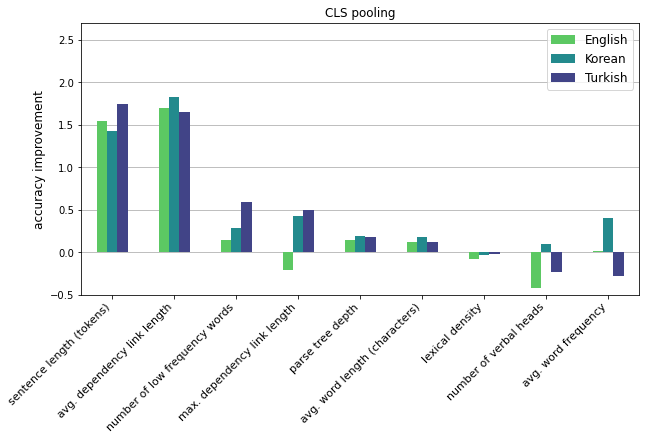

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

eval_metric = 'accuracy'

# get results for the chosen language, both finetuned and pretrained
df_pretrained_en = pretrained_frame.groupby('language').get_group('English').reset_index(drop=True)
df_finetuned_en = finetuned_frame.groupby('language').get_group('English').reset_index(drop=True)

df_pretrained_ko = pretrained_frame.groupby('language').get_group('Korean').reset_index(drop=True)
df_finetuned_ko = finetuned_frame.groupby('language').get_group('Korean').reset_index(drop=True)

df_pretrained_tr = pretrained_frame.groupby('language').get_group('Turkish').reset_index(drop=True)
df_finetuned_tr = finetuned_frame.groupby('language').get_group('Turkish').reset_index(drop=True)

# features and indeces are the same for the pretrained and finetuned dataframe and for each language

features = pretrained_frame['feature'].tolist()[:9]
print(features)

probing_data = []
for feature in features:
    
    data_per_feature = []
    
    index = df_pretrained_en.loc[df_pretrained_en['feature'] == feature].index.tolist()[0]

    # english
    results_pretrained_en = df_pretrained_en.groupby('feature').get_group(feature)
    results_finetuned_en = df_finetuned_en.groupby('feature').get_group(feature)

    score_pretrained_en = results_pretrained_en.loc[index].at[eval_metric]
    score_finetuned_en = results_finetuned_en.loc[index].at[eval_metric]
    
    difference_en = score_finetuned_en - score_pretrained_en
    
    # korean
    results_pretrained_ko = df_pretrained_ko.groupby('feature').get_group(feature)
    results_finetuned_ko = df_finetuned_ko.groupby('feature').get_group(feature)
    
    score_pretrained_ko = results_pretrained_ko.loc[index].at[eval_metric]
    score_finetuned_ko = results_finetuned_ko.loc[index].at[eval_metric]
    
    difference_ko = score_finetuned_ko - score_pretrained_ko
    
    # turkish
    results_pretrained_tr = df_pretrained_tr.groupby('feature').get_group(feature)
    results_finetuned_tr = df_finetuned_tr.groupby('feature').get_group(feature)
    
    score_pretrained_tr = results_pretrained_tr.loc[index].at[eval_metric]
    score_finetuned_tr = results_finetuned_tr.loc[index].at[eval_metric]
    
    difference_tr = score_finetuned_tr - score_pretrained_tr
    
    # collect all data
    data_per_feature.extend([feature, difference_en, difference_ko, difference_tr])
    probing_data.append(data_per_feature)

df = pd.DataFrame(probing_data,
                  columns=['linguistic feature', 'English', 'Korean', 'Turkish'])
df_sorted=df.sort_values(by='Turkish', ascending=False)

# plot grouped bar chart
ax = df_sorted.plot(x='linguistic feature',
        kind='bar',
        stacked=False,
        color = cm.viridis_r(np.linspace(0.25, 1.35, 5)),
        xticks=df.index, rot=45,
        zorder=3,
        figsize=(10,5),
        ylim=(-0.5,2.7))

ax.grid(axis='y', zorder=0)

ax.set_xticklabels(df_sorted['linguistic feature'], horizontalalignment='right', fontsize=11)
ax.set_xlabel('')
ax.set_ylabel(f'{eval_metric} improvement', fontsize=12)
ax.legend(fontsize=12)
ax.set_title('CLS pooling')
#ax.get_legend().remove()
print(ax)

plt.savefig('probing-cls-pooling.pdf', dpi=300, bbox_inches='tight')